In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
train_data_path = '/content/mount/MyDrive/Colab Notebooks/mnist_train.csv'
test_data_path = '/content/mount/MyDrive/Colab Notebooks/mnist_test.csv'

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

In [4]:
# mnist데이터를 접근하는 클래스 생성
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]  # index의 데이터중 1번째 값=정답
    target = torch.zeros((10))           # 10개값을 0으로 초기화
    target[label] = 1.0                  # 정답위치만 1.0으로 설정

    # index의 데이터중 1번째이후 모든 값을 얻고, 255로 나눠서 0~1사이의 값으로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)/255.0

    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
    
  

데이터를 로딩후 이미지로 출력

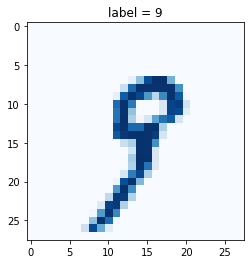

In [5]:
mnist_dataset = MnistDataset(train_data_path)
mnist_dataset.plot_image(19)

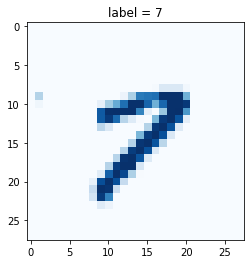

In [6]:
mnist_dataset.plot_image(29)

In [7]:
mnist_dataset[100]    # mnist_dataset.__getitem__(100) 호출

(5,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

신경망 만들기

In [8]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.LeakyReLU(0.02), # nn.Sigmoid(),
        nn.LayerNorm(200),
        nn.Linear(200, 10),
        nn.Sigmoid()
    )

    # self.loss_function = nn.MSELoss()   # mean squared error
    self.loss_function = nn.BCELoss()     # Binary Cross Entropy
    # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimizer = torch.optim.Adam(self.parameters())

    # 학습을 그래프화 시킬 때 사용할 변수
    self.counter = 0
    self.progress = []
    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)              # 순전파
    loss = self.loss_function(outputs, targets) # 오류값
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())         # 그래프 위한 값 저장
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)

    self.optimizer.zero_grad()                  # 오차역전파전에 기울기초기화
    loss.backward()                             # 오차역전파/기울기까지 구함
    self.optimizer.step()                       # 학습(오차값 사용하여 기울기조정)
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.'
            , grid=True, yticks=(0, 0.25, 0.5))
    pass

학습

In [9]:
# 실행시 시간을 출력해준다
%%time

C = Classifier()
epochs = 4
for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 17min 29s, sys: 9.5 s, total: 17min 39s
Wall time: 17min 37s


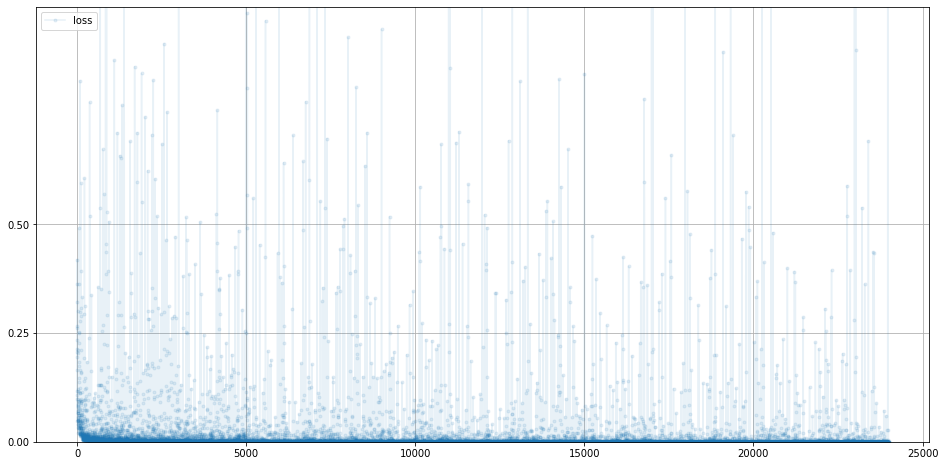

In [10]:
C.plot_progress()

테스트

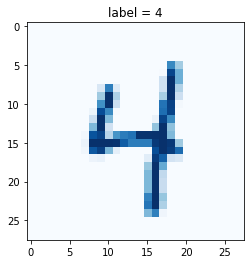

In [11]:
mnist_test_dataset = MnistDataset(test_data_path)
record = 19
mnist_test_dataset.plot_image(record)

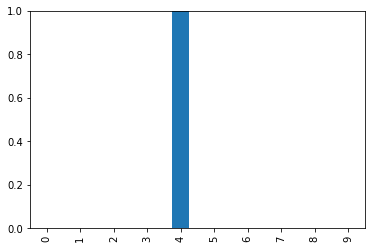

In [12]:
image_data = mnist_test_dataset[record][1]
output = C.forward(image_data)
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [13]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  if (answer.argmax() == label):
    score += 1
  items += 1

print(score, items, score/items)

9750 10000 0.975
